<img src="./resources/images/banner3.png" width="100%" alt="Encabezado MLDS">

# **Extracción de Características**
---

## **0. Integrantes del equipo de trabajo**
---

<table><thead>
  <tr>
    <th>#</th>
    <th>Integrante</th>
    <th>Documento de identidad</th>
  </tr></thead>
<tbody>
  <tr>
    <td>1</td>
    <td>Ivonne Cristina Ruiz Páez</td>
    <td>1014302058</td>  
  </tr>
  <tr>
    <td>2</td>
    <td>Diego Alejandro Feliciano Ramos</td>
    <td>1024586904</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Cristhian Enrique Córdoba Trillos</td>
    <td>1030649666</td>
  </tr>
</tbody>
</table>

## **1. Selección del Embedding**
---

Para el análisis de sentimientos sobre un corpus de 50.000 documentos en inglés provenientes de redes sociales, se seleccionó la técnica de embedding FastText por su capacidad de generar representaciones distribuidas de palabras que incorporan información subléxica a través del modelado de n-gramas de caracteres. A diferencia de Word2Vec, que representa cada palabra como un vector independiente, FastText descompone las palabras en subcomponentes, lo cual permite manejar de forma más robusta errores ortográficos, abreviaciones y palabras fuera del vocabulario (OOV), fenómenos frecuentes en el lenguaje informal y no estructurado característico de las plataformas sociales. Esta propiedad resulta especialmente útil para capturar de manera más precisa el contenido semántico de los textos breves y ruidosos. Además, su eficiencia computacional lo hace adecuado para corpus de tamaño medio-grande como el presente, permitiendo generar embeddings útiles para tareas de clasificación sin incurrir en los altos costos de cómputo de modelos basados en transformers. Si bien FastText no produce embeddings contextuales, su generalización a partir de subpalabras ofrece una mejora significativa sobre técnicas tradicionales como TF-IDF o Bag-of-Words, posicionándolo como una alternativa balanceada en términos de precisión y escalabilidad para tareas de análisis de sentimientos en dominios informales como las redes sociales.

## **2. Implementación del Embedding**
---

Implemente la estrategia de embedding a partir del conjunto de datos pre-procesado. Recuerde que:

- `sklearn`: permite implementar bolsas de palabras, TF-IDF y bolsas de N-grams a partir del módulo `sklearn.feature_extraction.text`.
- `gensim`: permite implementar word2vec, fasttext y doc2vec desde `gensim.models`.
- `spacy`: permite representar textos con embeddings pre-entrenados con el atributo `vector`.

In [ ]:
%pip install textblob kagglehub emoji gensim pandas numpy wordcloud contractions langdetect tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 394.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 3.3 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=792ee4263df5d3941805ac8693a4e328d497a6b54e21194de14ba200155869b8
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4b

In [ ]:
# Importa módulos para expresiones regulares, manejo de tiempo, registro de eventos, y procesamiento paralelo
#
import re
import time
import logging
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, TimeoutError

# Importa tqdm para mostrar barras de progreso
#
from tqdm import tqdm

# Importa kagglehub para interactuar con Kaggle y pandas para manipulación de datos
#
import nltk
import kagglehub
import pandas as pd

# Importa módulos para procesamiento de texto y detección de idioma
#
from emoji import demojize
import contractions
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from textblob import download_corpora

In [ ]:
# Función para detectar el idioma de un texto
def detectar_idioma(texto):
    try:
        return detect(str(texto))

    except:
        return "unknown"

In [ ]:
# Ruta del archivo CSV de salida
OUTPUT_CSV = "./dataset_limpio.csv"

# Nombre de la columna de texto en el dataset
TEXT_COLUMN = "statement"

# Tiempo máximo de espera en segundos
TIMEOUT_SEGUNDOS = 5

# Flag opcional para activar corrección ortográfica
CORREGIR_ORTOGRAFIA = True

In [ ]:
def limpiar_texto(texto):
    # 0. Asegurar que sea string
    texto = str(texto)

    # 1. Expandir contracciones ("I'm" -> "I am")
    texto = contractions.fix(texto)

    # 2. Demojizar
    texto = demojize(texto)

    # 3. Reemplazar URLs, menciones, hashtags
    texto = re.sub(r"http\S+|www\S+|https\S+", " ", texto)
    texto = re.sub(r"@\w+", " ", texto)
    texto = re.sub(r"#(\w+)", r"\1", texto)

    # 4. Reemplazar puntuación por espacios
    texto = re.sub(r"[^a-zA-Z]", " ", texto)

    # 5. Minúsculas
    texto = texto.lower()

    # 6. Tokenización
    tokens = word_tokenize(texto)

    # 7. Filtro de tokens
    tokens_filtrados = [
        token for token in tokens
        if token not in stop_words and len(token) > 1 and token.isalpha()
    ]

    # 8. Corrección ortográfica opcional
    if CORREGIR_ORTOGRAFIA:
        tokens_corregidos = []
        for token in tokens_filtrados:
            palabra_corregida = str(TextBlob(token).correct())
            tokens_corregidos.append(palabra_corregida)
    else:
        tokens_corregidos = tokens_filtrados

    # 9. Lematización
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens_corregidos]

    # 10. Retornar lista final de tokens
    return tokens_lemmatizados

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/diegof/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/diegof/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /User

In [ ]:
# Ejecuta la función de limpieza de texto con un límite de tiempo
#
def timeout_en_limpieza(texto):
    with ThreadPoolExecutor(max_workers=1) as executor:
        futuro = executor.submit(limpiar_texto, texto)
        try:
            return futuro.result(timeout=TIMEOUT_SEGUNDOS)
        except TimeoutError:
            logging.warning("⏱ Timeout en limpieza: " + str(texto[:40] + "\n"))
            return []
        except Exception as e:
            logging.error(f"❌ Error al limpiar texto: {texto[:40]}... -> {str(e)} \n")
            return []

In [ ]:
# Descarga la última versión del dataset - Kaggle
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)
# Carga la data del dataset
path = '/Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv'
df = pd.read_csv(path)

Path to dataset files: /kaggle/input/sentiment-analysis-for-mental-health


In [ ]:
# Procesa una lista de textos en paralelo utilizando múltiples procesos
#
def procesar_en_paralelo(funcion, lista_textos, num_procesos=None):
    if num_procesos is None:
        from os import cpu_count
        num_procesos = cpu_count()
    with mp.Pool(processes=num_procesos) as pool:
        resultados = list(tqdm(pool.imap(funcion, lista_textos), total=len(lista_textos)))
    return resultados

In [ ]:
if __name__ == "__main__":
    start = time.time()
    try:
        # Inicia el procesamiento y carga los datos
        logging.info("🚀 Inicio del procesamiento")
        print("📦 Cargando datos...")
        print(f"✅ {len(df)} documentos cargados.")
        logging.info(f"{len(df)} documentos cargados.")

        # Detecta el idioma de los documentos
        print("🌍 Detectando idioma...")
        df["lang"] = df[TEXT_COLUMN].apply(detectar_idioma)
        df_ingles = df[df["lang"] == "en"].copy()
        print(f"✅ Documentos en inglés: {len(df_ingles)}")

        # Procesa los textos en paralelo con límite de tiempo por fila
        print("🧠 Procesando en paralelo con timeout por fila...")
        textos = df_ingles[TEXT_COLUMN].tolist()
        textos_limpios = procesar_en_paralelo(timeout_en_limpieza, textos, num_procesos=11)

        # Guarda los resultados en un archivo .CSV
        print("💾 Guardando resultados...")
        df["clean_tokens"] = textos_limpios
        df.to_csv(OUTPUT_CSV, index=False)
        logging.info(f"Archivo guardado como: {OUTPUT_CSV}")
        print(f"✅ Archivo guardado como: {OUTPUT_CSV}")
    except Exception as e:
        # Maneja errores durante el procesamiento
        print("❌ Error durante el procesamiento:")
        print(e)
        logging.error(f"Error general del script: {str(e)}")
    finally:
        # Calcula y muestra el tiempo total de procesamiento
        end = time.time()
        elapsed = (end - start) / 60
        print(f"⏱ Tiempo total: {elapsed:.2f} minutos")
        logging.info(f"Tiempo total: {elapsed:.2f} minutos")


In [ ]:
!python ./resources/scripts/procesar_corpus.py

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/diegof/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/diegof/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /User

In [1]:
import requests
import pandas as pd
url = "https://drive.google.com/uc?export=download&id=1MfG4qCfqAlj7JBWS0WmLQVOZZvY8wPRf"
r = requests.get(url)

# Guarda el contenido descargado en un archivo local
with open("dataset.csv", "wb") as code:
  code.write(r.content)

df_cargado = pd.read_csv("dataset.csv")

In [2]:
import ast

def forzar_listas_en_columna(df, columna):
    """
    Convierte todos los valores de la columna en listas reales, si es posible.
    Devuelve un error si al final hay valores que no son listas.
    """
    def convertir(x):
        if isinstance(x, list):
            return x
        if isinstance(x, str) and x.strip().startswith("[") and x.strip().endswith("]"):
            try:
                return ast.literal_eval(x)
            except Exception as e:
                print(f"⚠️ Error al convertir: {x[:60]}... -> {e}")
                return []
        return []

    # Aplicar conversión
    df[columna] = df[columna].apply(convertir)

    # Validación final
    tipos_finales = df[columna].apply(type).value_counts()
    print("\n📊 Tipos después de forzar a listas:")
    print(tipos_finales)

    if any(t != list for t in df[columna].apply(type).unique()):
        raise TypeError("❌ Aún hay elementos que no son listas en la columna.")

    return df

# Usar en el dataframe cargado
df_corregido = forzar_listas_en_columna(df_cargado, "clean_tokens")


📊 Tipos después de forzar a listas:
clean_tokens
<class 'list'>    49710
Name: count, dtype: int64


In [3]:
from gensim.models import FastText

# Entrenamiento del modelo FastText
modelo_fasttext = FastText(
    sentences=df_corregido['clean_tokens'],         # lista de listas de tokens
    vector_size=100,                                # dimensión de los embeddings
    window=5,                                       # contexto de palabras
    min_count=2,                                    # ignora palabras con frecuencia < 2
    sg=1,                                           # usa Skip-gram (1) o CBOW (0)
    epochs=10                                       # número de épocas de entrenamiento
)

# Guardar el modelo para reutilización
modelo_fasttext.save("modelo_fasttext_gensim.model")

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Vectoriza un documento utilizando un modelo de palabras
def vectorizar_documento(tokens, modelo):
    vectores = [modelo.wv[token] for token in tokens if token in modelo.wv]
    if vectores:
        return np.mean(vectores, axis=0)
    else:
        return np.zeros(modelo.vector_size)

In [5]:
# Vectorizar todos los documentos preprocesados
X_vectores = np.array([vectorizar_documento(tokens, modelo_fasttext) for tokens in df_cargado['clean_tokens']])

# Ver tamaño del resultado
print(X_vectores.shape)

(49710, 100)


## **3. Exploración del Embedding**
---

Puede explorar la representación obtenida por medio de distintas técnicas de visualización o métricas:

- **Análisis de Correlaciones**: si tiene una variable objetivo, puede evaluar correlaciones entre los embeddings y dicha variable.
- **Nubes de palabras**: puede utilizar gráficos de tipo `wordcloud` para visualizar representaciones basadas en conteos
- **Distribuciones**: puede calcular histogramas o gráficos de densidad para mostrar la distribución de embeddings semánticos.

_________________


#### **Exploración General**
En esta sección se muestra algunas métricas resumen del corpus como el tamaño del vocabulario, las palabras más frecuentes, las palabras que presentan similitudes entre sí, similitud entre pares, y  se observa un vector para una palabra elegida.


In [6]:
# Ver el tamaño del vocabulario:
print(f"Tamaño del vocabulario: {len(modelo_fasttext.wv.key_to_index)}")

Tamaño del vocabulario: 16919


In [7]:
# Ver palabras más frecuentes de los documentos
palabras_frecuentes = modelo_fasttext.wv.index_to_key[:10]
print("Palabras más frecuentes:", palabras_frecuentes)

Palabras más frecuentes: ['like', 'feel', 'want', 'know', 'life', 'get', 'time', 'even', 'would', 'people']


In [8]:
# Palabras similares a "happy"
modelo_fasttext.wv.most_similar("happy", topn=10)

[('happywhen', 0.7598254084587097),
 ('sad', 0.6871853470802307),
 ('happier', 0.6779383420944214),
 ('joyful', 0.6507761478424072),
 ('joyous', 0.6496508121490479),
 ('happily', 0.6394078135490417),
 ('fun', 0.6290046572685242),
 ('cheerful', 0.6274338960647583),
 ('smile', 0.6239976286888123),
 ('laugh', 0.6199323534965515)]

In [9]:
# Similitud entre pares
print("Similitud entre happy y joyful: " + str(modelo_fasttext.wv.similarity("happy", "joyful")))
print("Similitud entre happy y angry: " + str(modelo_fasttext.wv.similarity("happy", "angry")))

Similitud entre happy y joyful: 0.6507762
Similitud entre happy y angry: 0.47824252


In [10]:
# Aqui miramos un ejemplo de un vector para una palabra dentro del corpus
palabra_ejemplo = "people"
if palabra_ejemplo in modelo_fasttext.wv:
    print(f"Vector de '{palabra_ejemplo}': {modelo_fasttext.wv[palabra_ejemplo]}")
else:
    print(f"La palabra '{palabra_ejemplo}' no está en el vocabulario.")

Vector de 'people': [-0.06303868  0.0710552  -0.2028589  -0.31131932  0.00385998  0.31954324
 -0.0596292  -0.05621289  0.08640249  0.00459773  0.1639911   0.04963085
 -0.09144822  0.21041715  0.06629922  0.14888893 -0.025497   -0.2924378
 -0.20188223  0.14352633 -0.247577    0.1691013   0.02821201  0.07213762
 -0.05134235 -0.05276295 -0.1070298   0.26511794 -0.1273058   0.1008614
  0.29666105 -0.01947387  0.06582895  0.14019372  0.07892193  0.43923384
  0.5543061   0.03033605 -0.0886824  -0.06372134 -0.19654688 -0.07468442
  0.32742083 -0.3804411  -0.0742676  -0.02265571 -0.5141475   0.14581475
  0.2730872   0.25295946  0.26262128  0.18408082  0.36225063 -0.11327606
 -0.07456332 -0.23505956 -0.11712094  0.49446276  0.07625933  0.2309545
  0.3064754   0.24622205 -0.09558847  0.00533243  0.06155283  0.34037164
  0.02651065 -0.07428361  0.07983094  0.1357725  -0.04873848  0.11798351
 -0.11878212 -0.38259578  0.02216341  0.32021052 -0.10017099  0.3295215
 -0.09674549  0.14262007  0.0981618

#### **Análisis de Correlaciones**
En nuestro corpus de datos, no disponemos de una variable objetivo específica. Esto limita nuestra capacidad para realizar un análisis de correlaciones entre los embeddings y una variable target.

#### **Nubes de palabras**
En las nubes de palabras no solamente se observan palabras clave y sus frecuencias, sino que también nos proporcionan una herramienta valiosa para el análisis semántico y la detección de patrones en el lenguaje utilizado en los tweets escritos por los usuarios. A continuación se muestra nubes de palabras relativas a palabras relevantes de acuerdo con nuestro objetivo del proyecto (análisis del sentimiento de publicaciones de twitter).

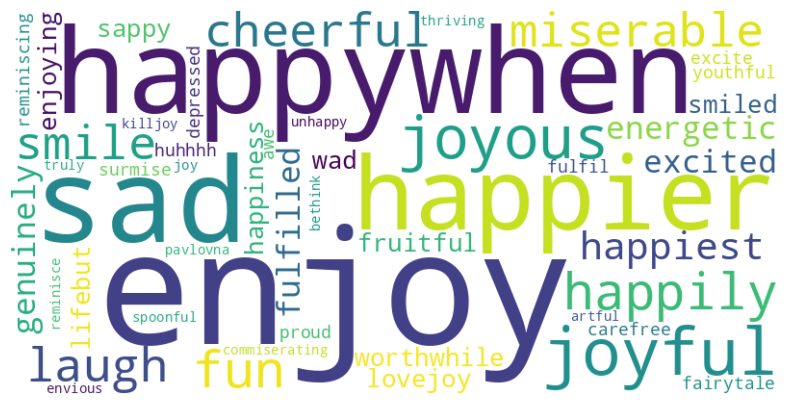

In [11]:
# Palabra HAPPY
# Genera y muestra una nube de palabras a partir de una lista de palabras
def nube_palabras(lista_palabras):
    texto = ' '.join(lista_palabras)
    nube = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(nube, interpolation='bilinear')
    plt.axis("off")
    plt.show()
# Obtiene las palabras más similares a "sad" utilizando el modelo FastText y genera la nube de palabras
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("happy", topn=50)]
nube_palabras(palabras_similares)

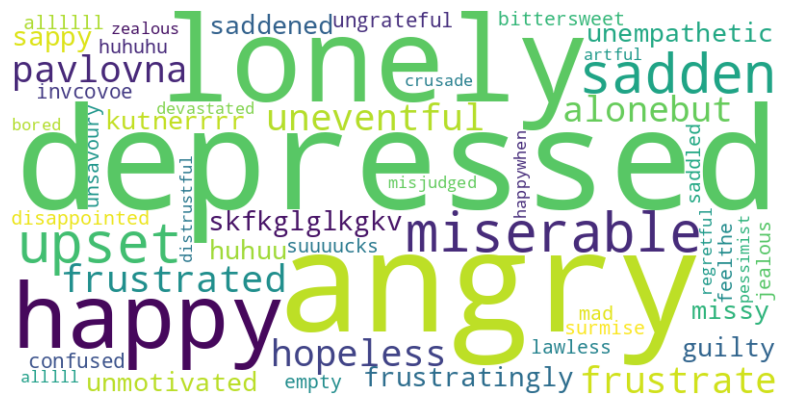

In [12]:
# Palabra Sad
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("sad", topn=50)]
nube_palabras(palabras_similares)

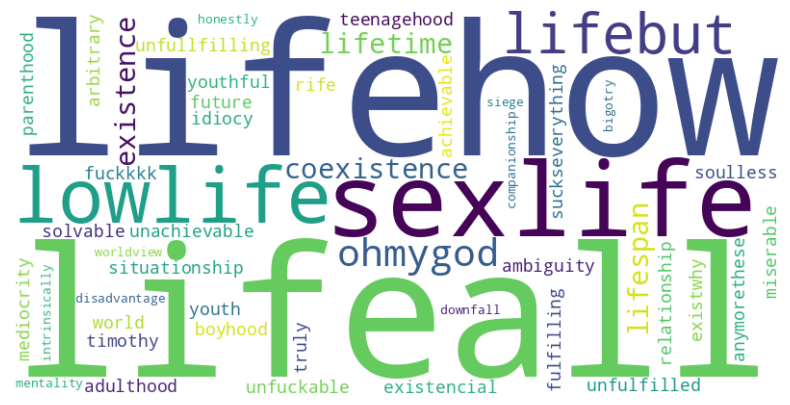

In [13]:
# Palabra Life
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("life", topn=50)]
nube_palabras(palabras_similares)

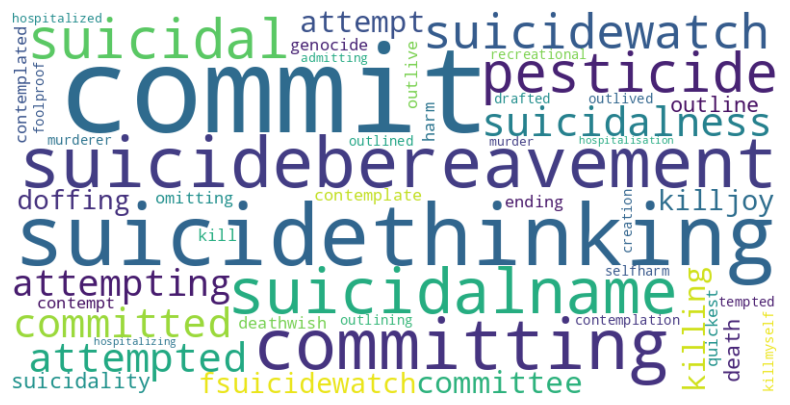

In [14]:
# Palabra Suicide
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("suicide", topn=50)]
nube_palabras(palabras_similares)

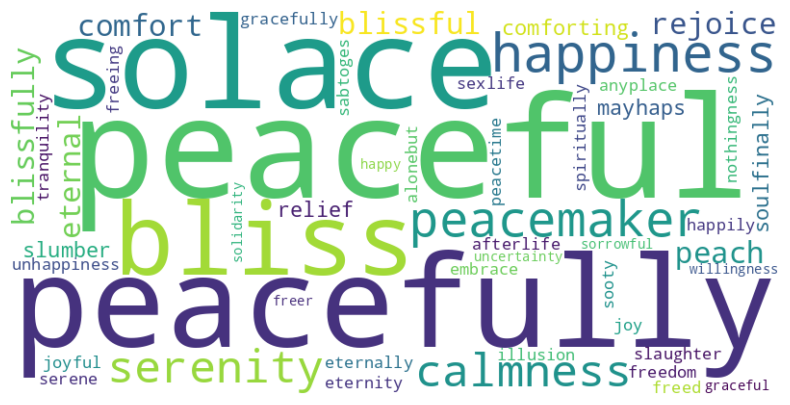

In [15]:
# Palabra Peace
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("peace", topn=50)]
nube_palabras(palabras_similares)

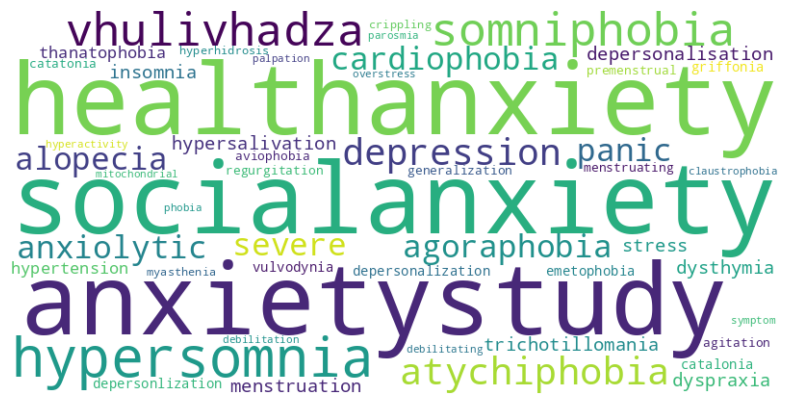

In [16]:
# Palabra Anxiety
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("anxiety", topn=50)]
nube_palabras(palabras_similares)

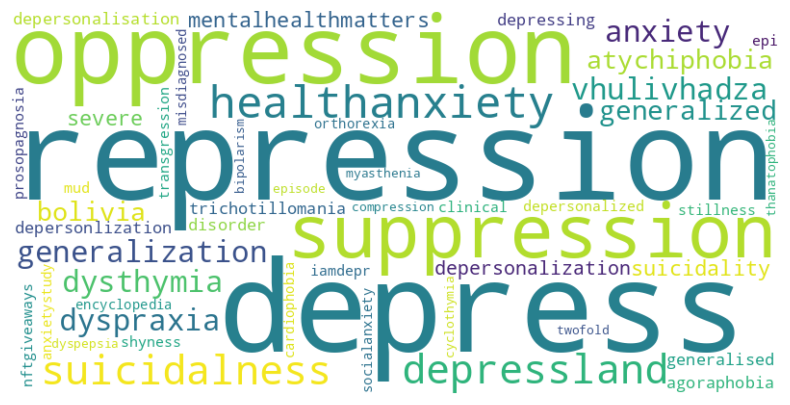

In [17]:
# Palabra Depression
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("depression", topn=50)]
nube_palabras(palabras_similares)

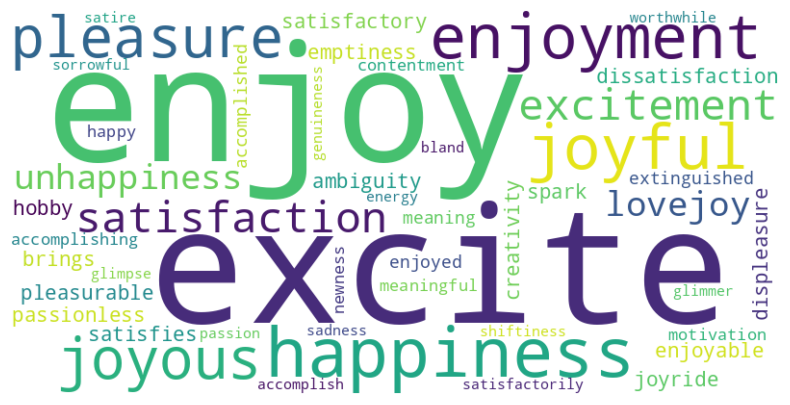

In [18]:
# Palabra Joy
palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("joy", topn=50)]
nube_palabras(palabras_similares)

**Distribuciones**

A continuación se muestra un histograma de los embeddings semánticos con las siguientes conclusiones:

* Distribución Normal: La forma de campana simétrica centrada alrededor de 0 sugiere que los valores de los embeddings siguen una distribución normal.

* Rango de Valores: Los valores de los embeddings varían aproximadamente entre -1.5 y 2.0. Esto indica que los embeddings tienen una amplitud moderada (lo que puede ser útil para capturar variaciones semánticas en el lenguaje).

* Frecuencia Alta en el Centro: La mayor frecuencia de valores se encuentra cerca de 0, lo que sugiere que muchos embeddings tienen valores cercanos a la media. Esto puede indicar que la mayoría de las palabras del corpus tienen representaciones semánticas similares en términos de magnitud.

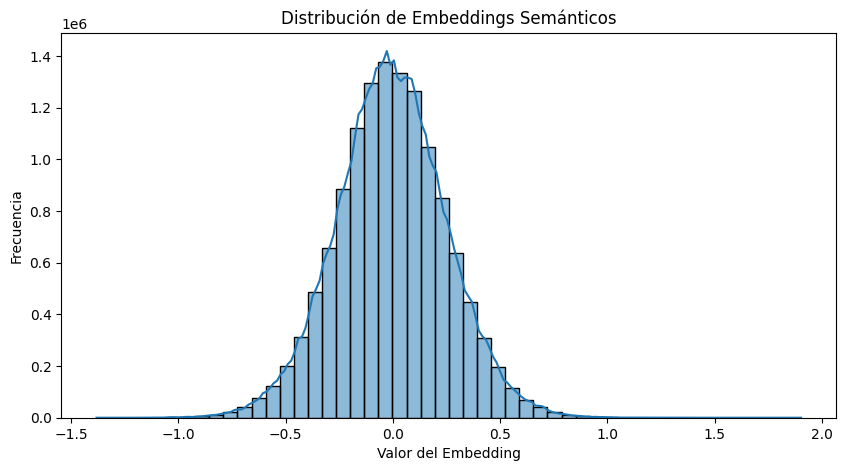

In [21]:
# Extraemos los embeddings para cada palabra en la columna "clean_tokens"
df_muestra = df_cargado.sample(frac=0.05)
embeddings = np.array([modelo_fasttext.wv[word] for tokens in df_muestra["clean_tokens"] for word in tokens if word in modelo_fasttext.wv])

# histograma
plt.figure(figsize=(10, 5))
sns.histplot(embeddings.flatten(), bins=50, kde=True)
plt.title("Distribución de Embeddings Semánticos")
plt.xlabel("Valor del Embedding")
plt.ylabel("Frecuencia")
plt.show()

## **Créditos**

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*